# Problem Set 3 - Andreas Bloch

## Imports

First, we'll import a set of functions that we'll use over and over again.

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import numpy as np
import scipy
import pandas as pd
import ggplot as gg
import itertools
import random
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec
from sklearn.manifold import TSNE
from math import isnan
from zipfile import ZipFile
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lemmatizer import Lemmatizer
from spacy.lang.en import LEMMA_INDEX, LEMMA_EXC, LEMMA_RULES
from string import punctuation
import re

## Data Preprocessing

Here we'll define the functionality to preprocesses the data for exercises 1 and 2

In [2]:
DATA_DIR = './data'
CASE_METADATA_FILENAME = 'case_metadata.csv'

class CounterMessage(object):

    def __init__(self):
        self.counter = 1
        self.last_action = ''

    def update(self, max_cnt, action):
        # reset counter for every new action
        if self.last_action != action:
            self.counter = 1
            self.last_action = action
            print('')
        # print status message
        print('\r{}/{}: {}.'.format(self.counter, max_cnt, action),
              end=' ' * 10, flush=True)
        self.counter += 1

def create_exercise_1_2_dataset():

    # create message counter
    counter = CounterMessage()

    # open cases zip file
    zfile = ZipFile('data/cases.zip')
    caseids = []
    raw_texts = {}

    # randomly shuffle files
    members = zfile.namelist()
    NUM_CASES = len(members)

    for case in members:
        year, caseid = case[:-4].split('_')
        with zfile.open(case) as f:
            raw_text = f.read().decode()
        raw_texts[caseid] = raw_text
        caseids.append(caseid)
        counter.update(NUM_CASES, 'opened')

    # do NLP
    nlp = spacy.load('en')
    spacy_documents = {}
    for caseid in caseids:
        spacy_documents[caseid] = nlp(raw_texts[caseid])
        counter.update(NUM_CASES, 'nlp-processed')

    # create punctuation remover
    punctuation_remover = str.maketrans('', '', punctuation)
    # create lemmatizer
    lemmatizer = Lemmatizer(LEMMA_INDEX, LEMMA_EXC, LEMMA_RULES)

    def filter_and_transform(token):
        # get the token's word(s)
        word = ''.join(token.text)
        # replace newlines with spaces
        word = word.replace('\r', ' ').replace('\n', ' ')
        # remove punctuation
        word = word.translate(punctuation_remover)
        # replace multiple subsequent spaces with one space
        word = re.sub(' +', ' ', word)
        # check that word still has some text (not just one char or space)
        if len(word) <= 1:
            return False, (word, token.pos_)
        # normalize numbers (28, 28th, 1st, ...)
        if any(char.isdigit() for char in word):
            return False, (word, token.pos_)
        # lemmatize the word
        lemmas = lemmatizer(word, token.pos)[0]
        # try to lemmatize the word
        if isinstance(lemmas, (list,)) and len(lemmas) > 0:
            # pick the first option if several lemmas were found
            word = lemmas[0]
        else:
            # no lemma was found (just keep the original word)
            word = word
        # convert the word to lowercase
        word = word.lower()
        # remove stopwords
        if word in STOP_WORDS:
            return False, (word, token.pos_)
        # finally, return the filtered word and type
        return True, (word, token.pos_)


    # create filtered texts
    case_sentences = {k: [] for k in caseids}

    # process sentences of cases
    for caseid in caseids:
        spacy_document = spacy_documents[caseid]
        # process each sentence separately
        curr_case_sentences = []
        for sentence in spacy_document.sents:
            # create a list of tokens for each sentence
            sentence_tokens = []
            # filter the tokens in the case
            for token in sentence:
                take_token, filtered_token = filter_and_transform(token)
                if take_token:
                    sentence_tokens.append(filtered_token[0])
            # append list of processed tokens for this document
            if len(sentence_tokens) > 0:
                curr_case_sentences.append(sentence_tokens)
        # save list of all sentences of this case
        if len(curr_case_sentences) > 0:
            case_sentences[caseid] = curr_case_sentences
        else:
            print('case' + str(caseid) + 'has no sentences!')

        counter.update(NUM_CASES, 'sentences filtered.')

    # load metadata to get full data
    full_data = {}
    case_metadata = pd.read_csv(os.path.join(DATA_DIR,
                                             CASE_METADATA_FILENAME)).values
    for caseid, case_reversed, judge_id, year,\
        x_republican, log_cites in case_metadata:
        if caseid in case_sentences and not isnan(x_republican):
            full_data[caseid] = [case_sentences[caseid], x_republican]

    # create data frame
    df = pd.DataFrame.from_dict(full_data,
                                orient='index',
                                columns=['sentences', 'republican'])

    # store data frame
    df.to_pickle('data.pkl')

Let's create the preprocessed data for exercises 1 and 2 (will be saved into 'data.pkl')

In [3]:
create_exercise_1_2_dataset()


5762/5762: opened.                                                                                                                                                                                                                                                                                                                                                                                                               
5762/5762: nlp-processed.          
5762/5762: sentences filtered..                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

## Exercise 1

**Q:** Train a word embedding (Word2Vec, GloVe, ELMo, BERT, etc) on your corpus, once with a small window (e.g. 2) and again with a long window (e.g. 16). What do you expect to change for the different window sizes? Pick a sample of 100 words and visualize them in two dimensions, to demonstrate the difference between the models.

**A:** First, let's define the functionality that performs a word-embedding (skip-gram) for a set of sentences.

In [4]:
class loss_callback(CallbackAny2Vec):
    '''callback to print loss after each epoch.'''
    def __init__(self):
        self.epoch = 0
        self.last_loss = 0

    def on_epoch_end(self, model):
        cumulative_loss = model.get_latest_training_loss()
        loss = cumulative_loss - self.last_loss
        self.last_loss = cumulative_loss
        print('Epoch %3d, Loss: %12.2f' % (self.epoch, loss))
        self.epoch += 1


def train_w2v(sentences, window):
    """
    Trains and returns a word2vec model (skip-gram).
    :param sentences: the sentences to use for training, e.g.,
    [['it', 'was', ...],...,['today', 'i', 'will', ...]]
    :param window:
    :return: trained word2vec model
    """

    # shuffle sentences (in-place)
    random.shuffle(sentences)

    # create and train word2vec model
    w2v = Word2Vec(
        sentences,          # list of tokenized sentences
        size=300,           # embedding dimensionality
        window=window,      # context window size
        min_count=5,        # only include words with minimum word count
        workers=16,         # num threads (parallelization)
        sg=1,               # use skip-gram model
        negative=20,        # number of negative samples per positive sample
        ns_exponent=3/4,    # damping of frequent words for neg. sampling
        sample=1e-3,        # downsample frequent words up to threshold
        alpha=0.025,        # initial learning rate
        min_alpha=0.0001,   # linearly drop learning rate until
        seed=23,            # random number seed
        iter=20,            # number of iterations over the corpus
        sorted_vocab=1,     # sort the vocabulary by descending frequency
        compute_loss=True,  # compute training loss
        callbacks=[         # callbacks
            loss_callback() # training loss callback (every epoch)
        ]
    )

    # done training, so delete context vectors
    # precompute L2-normalized vectors used for similarities
    # (forget original vectors and keep normalized vectors)
    # mdel becomes read-only and cannot be trained anymore
    w2v.wv.init_sims(replace=True)

    return w2v

Further, let's define the to create a 2D-visualization of the embedding via t-SNE.

In [5]:
def train_and_get_visualization(w2v, window_size, num_words=200):
    """
    Visualizes a word embedding (instances, dim) in 2 dimensions.
    :param w2v: word-embeddings (instances, dim)
    :param num_words: number of words to visualize (make sure embedding vectors
    are sorted in desired order!) the first 'num_words' vectors will be
    displayed
    :return: None
    """

    # create tsne object
    tsne = TSNE(n_components=2,
                perplexity=50,              
                early_exaggeration=12.0,
                learning_rate=200.0,
                n_iter=1000,
                n_iter_without_progress=300,
                metric = scipy.spatial.distance.cosine,
                verbose=1)

    # the words are sorted by their frequencies,
    # so we get the most frequent 'num_words'
    chart_data = pd.DataFrame(list(enumerate(w2v.wv.index2word, 0))[:num_words],
                              columns=['word_index', 'word'])

    # get word embedding vectors
    word_vectors = w2v.wv.vectors[:num_words,:]

    # create 2D representation for word embeddings via TSNE
    wv_tsne = tsne.fit_transform(word_vectors)

    # get x and y coordinates in 2D visualization
    chart_data['x'] = wv_tsne[:, 0]
    chart_data['y'] = wv_tsne[:, 1]

    # create and show chart
    
    chart = gg.ggplot(chart_data, gg.aes(x='x', y='y', label='word')) + \
            gg.geom_text(size=10, alpha=.8, label='word')
    chart.title = 'Window Size: '+str(window_size)
    return chart

This function will be useful to convert the dataframe columns into lists of sentences

In [6]:
# flattens a dataframe column (= list of lists of sent.) to list of sent.
# where sent. = list of stemmed words
def flatten(df_col):
    # convert dataframe column to list of lists
    list_of_list_of_sentences = df_col.tolist()
    # flatten list of lists
    L = list(itertools.chain.from_iterable(list_of_list_of_sentences))
    return L

Now, let's get to the embedding process:

In [7]:
# read preprocessed data frame
df = pd.read_pickle('data.pkl')

# get all sentences
sentences = flatten(df['sentences'])

# train embeddings with window size of 2 and 16
w2v_2 = train_w2v(sentences, window=2)
w2v_16 = train_w2v(sentences, window=16)

Epoch   0, Loss:   3028862.00
Epoch   1, Loss:   2521678.00
Epoch   2, Loss:   2334689.00
Epoch   3, Loss:   2424485.00
Epoch   4, Loss:   3180235.00
Epoch   5, Loss:   2637016.00
Epoch   6, Loss:   2772657.00
Epoch   7, Loss:   2650442.00
Epoch   8, Loss:   2992980.00
Epoch   9, Loss:   2823214.00
Epoch  10, Loss:   1808112.00
Epoch  11, Loss:   2256428.00
Epoch  12, Loss:   2689286.00
Epoch  13, Loss:   1719448.00
Epoch  14, Loss:   2140580.00
Epoch  15, Loss:   1733912.00
Epoch  16, Loss:   2063840.00
Epoch  17, Loss:   3095780.00
Epoch  18, Loss:   1654688.00
Epoch  19, Loss:   2496572.00
Epoch   0, Loss:  13554064.00
Epoch   1, Loss:   6789278.00
Epoch   2, Loss:   5786298.00
Epoch   3, Loss:   5743660.00
Epoch   4, Loss:  13756968.00
Epoch   5, Loss:   9205584.00
Epoch   6, Loss:   6824356.00
Epoch   7, Loss:   5841960.00
Epoch   8, Loss:   2091560.00
Epoch   9, Loss:   3169936.00
Epoch  10, Loss:   1620256.00
Epoch  11, Loss:   1731360.00
Epoch  12, Loss:   1696608.00
Epoch  13,

Now, let's train the visualizations:

In [8]:
# train 2D visualization of embeddings for window sizes of 2 and 16
tsne_2_chart = train_and_get_visualization(w2v_2, 2, num_words=100)
tsne_16_chart = train_and_get_visualization(w2v_16, 16, num_words=100)

[t-SNE] Computing 99 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.000s...
[t-SNE] Computed neighbors for 100 samples in 0.346s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 0.263339
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.416550
[t-SNE] KL divergence after 1000 iterations: 0.366523
[t-SNE] Computing 99 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.000s...
[t-SNE] Computed neighbors for 100 samples in 0.343s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 0.285375
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.988808
[t-SNE] KL divergence after 850 iterations: 0.339841


I expect that with the smaller window size words are grouped in a more paradigmatic manner. In this case words are close to their potential substitutes (e.g., dog VS cat). The training of each word is made out of little context, which makes the words more substitutable (but also change the topic). So the substitutes may not necessarily belong to the same topic, or mean the same thing, but they just fit as a substitute for that word in a small context of a sentence.

I expect that with a larger window, since in that case every time we're training with a larger context, the model learns better which word exactly fits into which context. So I expect words to be grouped by topic (rather being close to substitutes that could be fit in their place to get a syntactically valid sentence, but likely with a very different meaning). So I expect the words to be grouped in a syntagmatic fashion.

The effect isn't that evident in the results below. The two graphs show the 100 most frequent words embedded in 2D via t-SNE. For example, one can see that in the window size of 16 the words 'business' and 'company' are grouped (as they belong to the same topic), whereas with the window size of 2 the words are apart (company is next to its substitutes 'co', 'inc' etc, far apart from business).

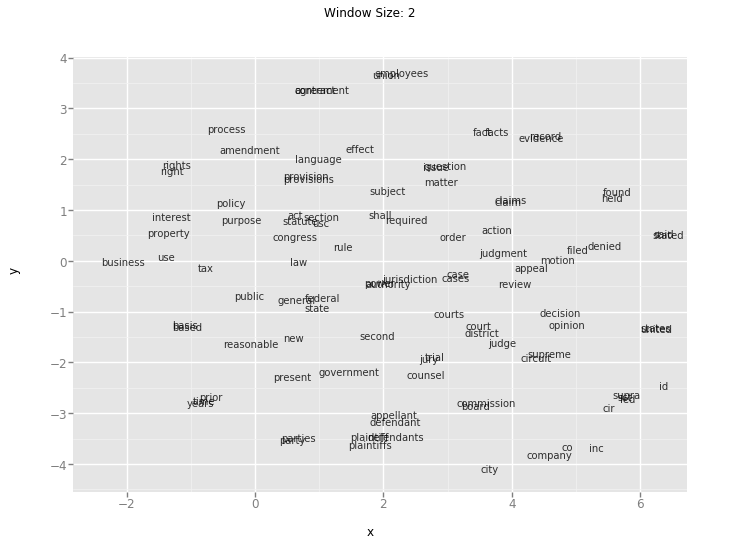

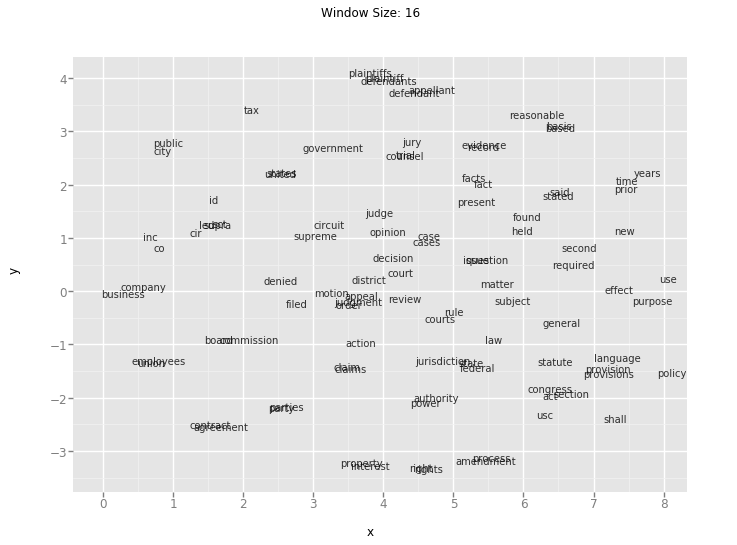

In [9]:
# show 2D visualizations
tsne_2_chart.show()
tsne_16_chart.show()

## Exercise 2

**Q:** Train separate word embeddings for Republican and Democrat judges. Use your word embeddings to list the adjectives most associated with a social group or concept of your choice (following, for example, the method in Caliskan et al 2017 or Kozlowski et al 2018), and analyze differences by judge party.

**A:** I've used the approach of Kozlowski (mean of pairs) to compute the dimensions of the concepts 'gender', 'class' and 'race' and I've analyzed how various terms of the topics 'jobs' and 'crimes' are placed in the republican and democrat embedding.

First we'll get all the sentences written by republican and democrat judges

In [10]:
# read preprocessed data frame
df = pd.read_pickle('data.pkl')

# get all republican and democrat sentences
republican_sentences = flatten(df[df['republican'] > 0.5]['sentences'])
democrat_sentences = flatten(df[df['republican'] < 0.5]['sentences'])

print(len(republican_sentences))
print(len(democrat_sentences))

375810
392168


Now we'll train the corresponding embeddings

In [11]:
# train republican and democrat embeddings
w2v_republican = train_w2v(republican_sentences, window=16)
w2v_democrat = train_w2v(democrat_sentences, window=16)

Epoch   0, Loss:   5511577.00
Epoch   1, Loss:   5866679.00
Epoch   2, Loss:   5211086.00
Epoch   3, Loss:   5401818.00
Epoch   4, Loss:   5183002.00
Epoch   5, Loss:   5121732.00
Epoch   6, Loss:   5411254.00
Epoch   7, Loss:   4560952.00
Epoch   8, Loss:   7606512.00
Epoch   9, Loss:   3920756.00
Epoch  10, Loss:   3692988.00
Epoch  11, Loss:   6963352.00
Epoch  12, Loss:   2915028.00
Epoch  13, Loss:   1103360.00
Epoch  14, Loss:   1270616.00
Epoch  15, Loss:   1196528.00
Epoch  16, Loss:    708336.00
Epoch  17, Loss:    763440.00
Epoch  18, Loss:    662072.00
Epoch  19, Loss:    729496.00
Epoch   0, Loss:   6303330.50
Epoch   1, Loss:   4213216.50
Epoch   2, Loss:   4078188.00
Epoch   3, Loss:   3760537.00
Epoch   4, Loss:   3049088.00
Epoch   5, Loss:   4568900.00
Epoch   6, Loss:   4542260.00
Epoch   7, Loss:   6918476.00
Epoch   8, Loss:   5319080.00
Epoch   9, Loss:   2778784.00
Epoch  10, Loss:   6760024.00
Epoch  11, Loss:   3738264.00
Epoch  12, Loss:   5377604.00
Epoch  13,

This function is used to get the dimension vector for a concept (e.g., gender, race or class). I've mostly used Kozlowski's proposed pairs (as long as the vocabulary item was defined) and I've also added some of my own.

In [12]:
def get_dimension_vector(concept_name, w2v):
    """
    Returns the dimension vector (direction of dimension)
    of a certain concept.
    :param concept_name: the concept to get the dimension vector for
    :param w2v: the word embedding
    :return: the vector pointing into the direction of the concept
    """

    # determine pairs to compute dimension direction
    pairs = None
    if concept_name == 'gender':
        pairs = [
            ('man', 'woman'),
            ('men', 'women'),
            # ('he', 'she'),
            # ('him', 'her'),
            # ('his', 'hers'),
            ('boy', 'girl'),
            ('boys', 'girls'),
            ('male', 'female'),
            # ('masculine', 'feminine')
        ]
    elif concept_name == 'race':
        pairs = [
            ('black', 'white'),
            ('blacks', 'whites'),
            ('african', 'european'),
            # ('african', 'caucasian'),
        ]
    elif concept_name == 'class':
        pairs = [
            ('rich', 'poor'),
            #('richer', 'poorer'),
            #('richest', 'poorest'),
            #('affluence', 'poverty'),
            #('affluent', 'impoverished'),
            #- ('expensive', 'inexpensive'),
            #- ('luxury', 'cheap'),
            #('opulent', 'needy')
            # ---------------------
            ('rich', 'broke'),
            ('wealthy', 'poor'),
            ('wealthy', 'broke'),
            #- ('expensive', 'cheap'),
            #- ('costly', 'economical'),
            #- ('precious', 'worthless'),
            #('luxurious', 'spartan'),
            #('aristocratic', 'lower-class'),
            #('aristocratic', 'plebeian'),
            #('upper', 'lower'), # class
        ]
    else:
        raise RuntimeError('invalid concept_name!')

    # compute dimension direction through average
    avg = np.zeros(w2v.vector_size)
    for pair in pairs:
        current = w2v.wv[pair[0]] - w2v.wv[pair[1]]
        avg += current
    avg /= np.linalg.norm(avg)
    return avg

This function is used to compute the x/y-coordinates of terms in a topic according to two concepts.

In [13]:
def compute_positions(w2v, concepts, topic):
    """
    Computes the position of terms in a topic according to two concepts
    in a word embedding
    :param w2v: the word embedding to use
    :param concepts: the concepts used as x and y axis
    :param topic: the topics to compute the positions for according to the
    concepts
    :return: positions (x,y) of the terms in the topic according to concepts
    """

    # create a data frame containing a row for each topic
    positions = pd.DataFrame(list(enumerate(topic, 0)),
                              columns=['word_index', 'word'])

    # get concept dimension directions
    concept_1_dim = get_dimension_vector(concepts[0], w2v)
    concept_2_dim = get_dimension_vector(concepts[1], w2v)

    # initialize x and y coordinates for terms in topic
    x = np.zeros(len(topic))
    y = np.zeros(len(topic))

    # for each topic in the topic
    for i, term in enumerate(topic, 0):
        # get the embedding of that instance
        term_embedding = w2v.wv[term]
        # determine association to concepts
        # determine (x/y)-coordinates
        x[i] = np.dot(concept_1_dim, term_embedding)
        y[i] = np.dot(concept_2_dim, term_embedding)

    # assign x and y coordinates
    positions['x'] = x
    positions['y'] = y

    return positions

This function shows the comparision of positions according to two concepts of terms in a topic for republicans and democrats.

In [24]:
def show_comparison_chart(rep_data, dem_data, concepts, topic):
    
    # initialize plot
    plt.figure(figsize=(16,16))

    # extract coordinates
    x_coords1 = rep_data['x']
    y_coords1 = rep_data['y']
    x_coords2 = dem_data['x']
    y_coords2 = dem_data['y']

    # determine axis span
    ax_max = np.max(np.abs(np.concatenate((x_coords1, x_coords2, y_coords1, y_coords2))))*1.2

    # keep track of last point for legend
    rep = None
    dem = None

    # define text offset
    txt_off = 0.003

    # for each term in the topic
    for i, term in enumerate(topic):
        # get the coordinates of the first point
        x1 = x_coords1[i]
        y1 = y_coords1[i]
        # get the coordinates of the second point
        x2 = x_coords2[i]
        y2 = y_coords2[i]
        # create first point (republican)
        rep = plt.scatter(x1, y1, marker='.', color='red')
        plt.text(x1 + txt_off, y1 + txt_off, term, fontsize=22, color='red')
        # create second point (democrat)
        dem = plt.scatter(x2, y2, marker='.', color='blue')
        plt.text(x2 + txt_off, y2 + txt_off, term, fontsize=22, color='blue')
        # connect points with line
        plt.plot([x1, x2], [y1, y2], color='gray', alpha=0.3)

    # add legend
    plt.legend([rep, dem], ['Republican', 'Democrat'], loc='upper right')

    # adjust axes
    axes = plt.gca()
    axes.set_xlim([-ax_max, ax_max])
    axes.set_ylim([-ax_max, ax_max])
    axes.set_aspect('equal', 'box')
    ylim = axes.get_ylim()
    xlim = axes.get_xlim()
    plt.vlines(0, ylim[0], ylim[1], colors='gray')
    plt.hlines(0, xlim[0], xlim[1], colors='gray')
    
    # define concept to axis title mapping
    concept_to_titles = {
        'gender': ['female', 'Gender', 'male'],
        'race': ['white', 'Race', 'black'],
        'class': ['poor', 'Class', 'rich']
    }

    # get axis names
    x_lo = concept_to_titles[concepts[0]][0]
    x_mi = concept_to_titles[concepts[0]][1]
    x_hi = concept_to_titles[concepts[0]][2]
    y_lo = concept_to_titles[concepts[1]][0]
    y_mi = concept_to_titles[concepts[1]][1]
    y_hi = concept_to_titles[concepts[1]][2]

    # annotate axes with axis names
    plt.xlabel(x_lo + '  <----  '+x_mi+'  ---->  '+x_hi, fontsize=18)
    plt.ylabel(y_lo + '  <----  '+y_mi+'  ---->  '+y_hi, fontsize=18)

    plt.show()

Now let's analyze how certain terms of a topic are placed (according to two concepts) in the word embeddings for democrats and republicans

In our first experiment we'll analyze how jobs are positioned according to gender and class:

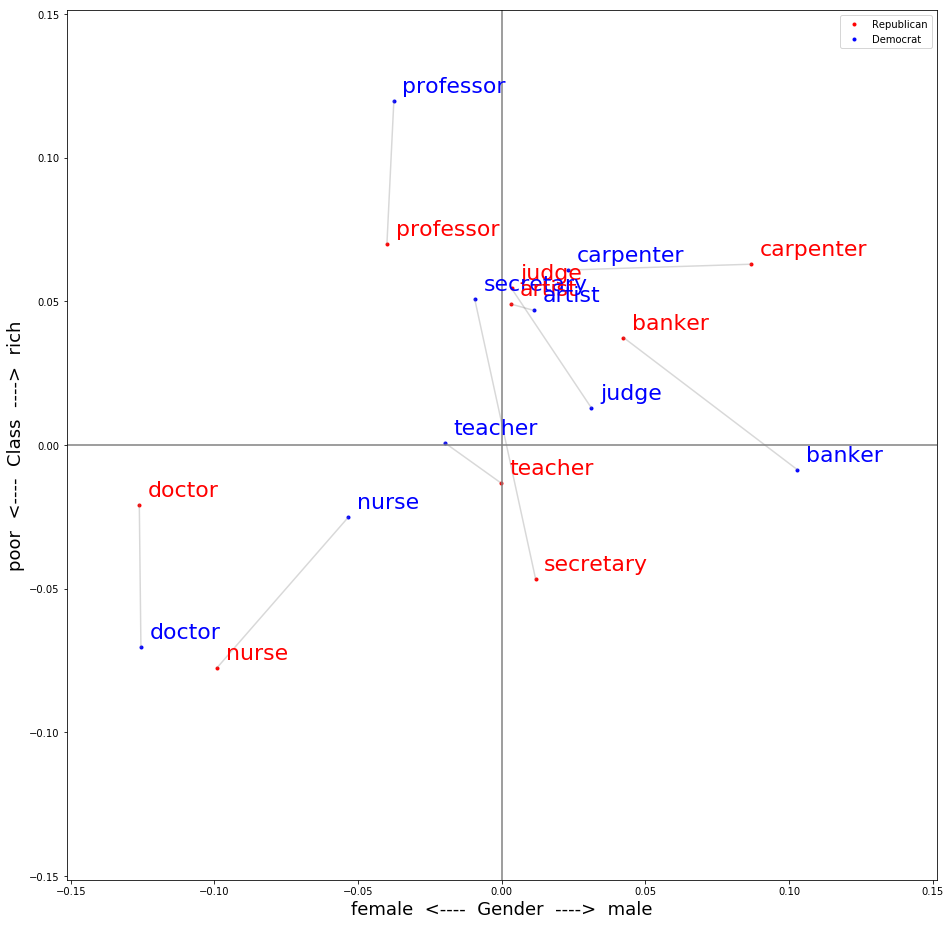

In [25]:
# create job topic
jobs = [
    'nurse',
    'carpenter',
    'judge',
    'secretary',
    'banker',
    'artist',
    'doctor',
    'teacher',
    'professor'
]
# use gender and class concepts
concepts = ['gender', 'class']
# get position of topic items according to concepts for each party
rep_data = compute_positions(w2v_republican, concepts, jobs)
dem_data = compute_positions(w2v_democrat, concepts, jobs)
# show the comparison plot
show_comparison_chart(rep_data, dem_data, concepts, jobs)

As one can see jobs like 'carpenter' and 'banker' are are associated with 'male' and 'nurse' is associated with 'female'. There aren't any significant differences between the republican and democrat embeddings. A surprising thing is that 'doctor' is the term most associated with 'female' (even more than nurse) in both embeddings. Another surprising fact is that 'professor' is the job that is the most associated with 'rich' - even more than the job 'banker'. The terms 'carpenter' and 'professore' are associated more with prosperity than the term 'banker'.

In our second experiment we'll analyze how crimes are positioned according to gender and race:

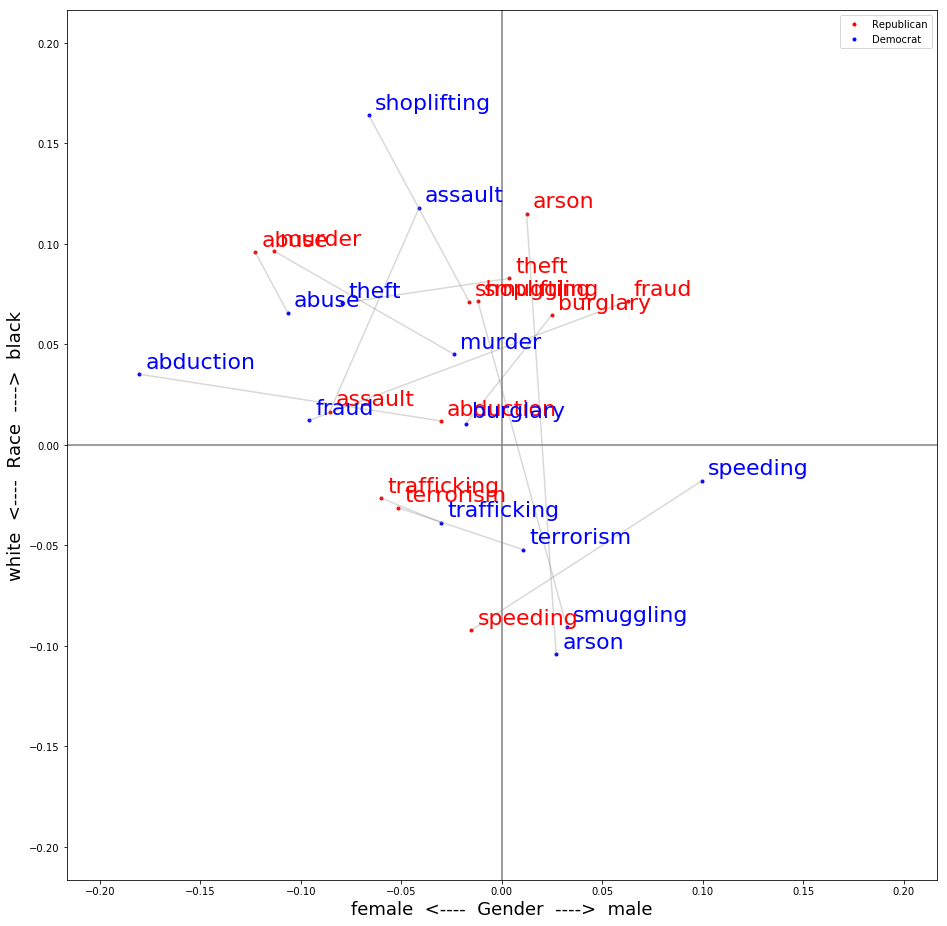

In [26]:
# create crime topic
crimes = [
    'murder',
    'assault',
    'theft',
    'trafficking',
    'terrorism',
    'smuggling',
    'shoplifting',
    'speeding',
    'abduction',
    'arson',
    'burglary',
    'abuse',
    'fraud'
]
# use gender and race concepts
concepts = ['gender', 'race']
# get position of topic items according to concepts for each party
rep_data = compute_positions(w2v_republican, concepts, crimes)
dem_data = compute_positions(w2v_democrat, concepts, crimes)
# show the comparison plot
show_comparison_chart(rep_data, dem_data, concepts, crimes)

As one can see, the crimes 'abduction', 'abuse', 'shoplifting' and assault are all associadet with the 'black'-'female' quadrant for both embeddings. The crimes 'speeding', 'trafficking' and 'terrorism' are all in the 'white' half-plane for both embeddings. The crimes 'abduction', 'fraud', 'assault', 'murder', 'theft', 'abuse', 'shoplifting', 'burglary' are all in the 'black' half-plane. An interesting fact is that 'arson' and 'smuggling' are in completely different 'race'-halfplanes in each of the embeddings. A crime that associates strongly with 'female' in both embeddings is 'abuse'. The republican embedding places no crime in the 'white'-'male' quadrant, whereas the democrate embedding places no crime in the 'black'-'male' quadrant.